Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/mushrooms.csv')

# Change column names: replace hyphens with underscores
df.columns = [col.replace('-', '_') for col in df]

In [3]:
df['class'].value_counts(normalize=True)

e    0.517971
p    0.482029
Name: class, dtype: float64

In [4]:
# Split data into train, val, and test
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, random_state=42)
train, val = train_test_split(train, random_state=42)

train.shape, val.shape, test.shape

((4569, 23), (1524, 23), (2031, 23))

In [37]:
target = 'class'
features = train.columns.drop([target] + ['veil_type'])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [38]:
import category_encoders as ce
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

X = df[features]
y = df[target]

# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

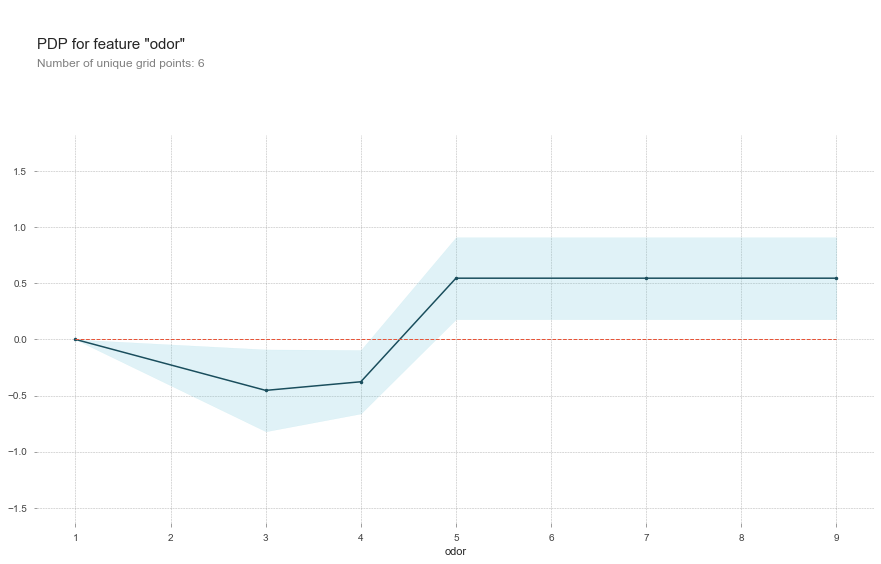

In [29]:
# Use Pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'odor'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

In [30]:
feature = 'odor'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

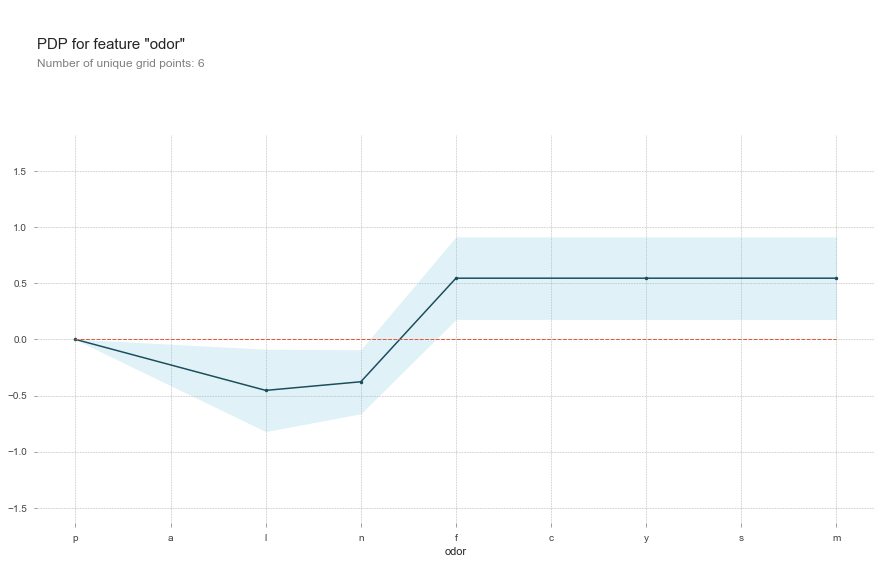

In [31]:
pdp.pdp_plot(pdp_dist, feature)

# Automatically change the xticks labels
plt.xticks(category_codes, category_names);

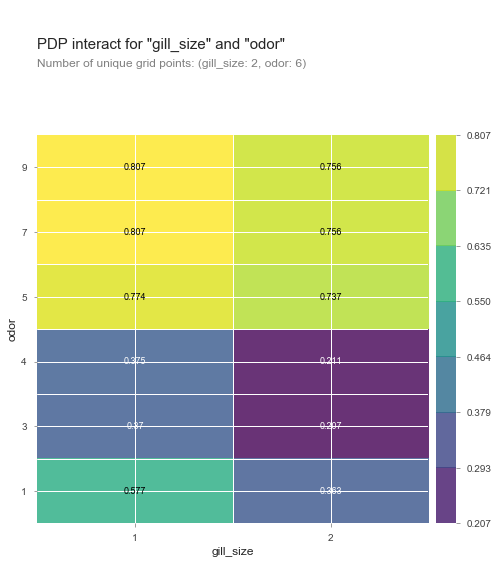

In [15]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['gill_size', 'odor']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [32]:
feature = 'gill_size'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)

In [33]:
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names1 = feature_mapping.index.tolist()
category_codes1 = feature_mapping.values.tolist()

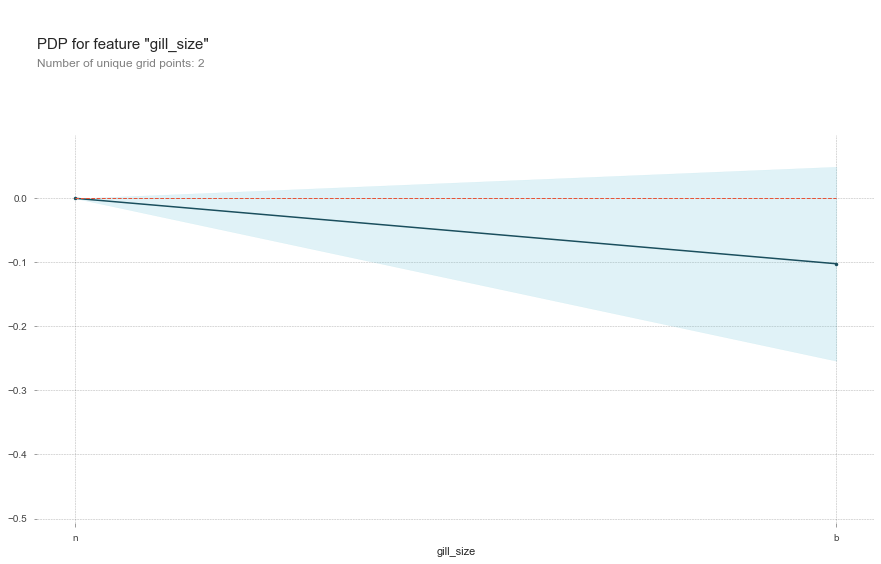

In [34]:
pdp.pdp_plot(pdp_dist, feature)
# Automatically change the xticks labels
plt.xticks(category_codes1, category_names1);

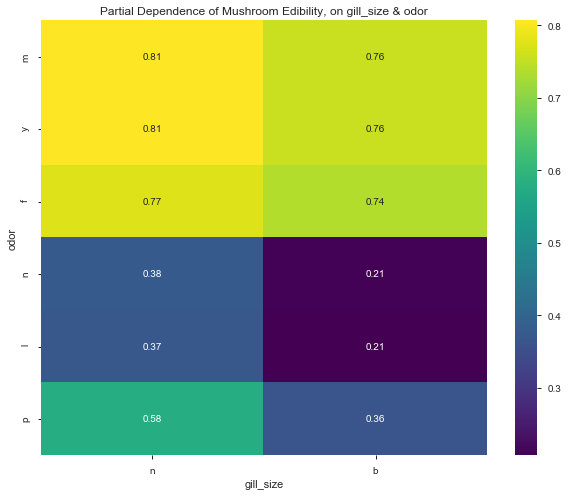

In [22]:
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], # First feature on x axis
    index=features[1]    # Next feature on y axis
)[::-1]  # Reverse the index order so y axis is ascending

pdp = pdp.rename(
    index=dict(zip(category_codes, category_names)),
    columns=dict(zip(category_codes1, category_names1))
)
plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial Dependence of Mushroom Edibility, on gill_size & odor');

In [36]:
X_encoded.columns

Index(['gill_size', 'odor'], dtype='object')

In [39]:
feature = 'spore_print_color'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)

In [40]:
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

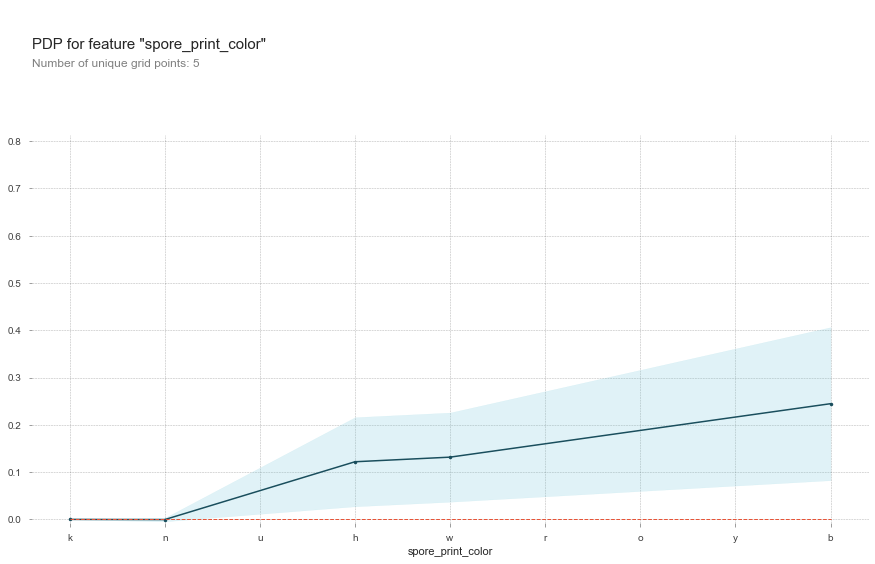

In [41]:
pdp.pdp_plot(pdp_dist, feature)
# Automatically change the xticks labels
plt.xticks(category_codes, category_names);

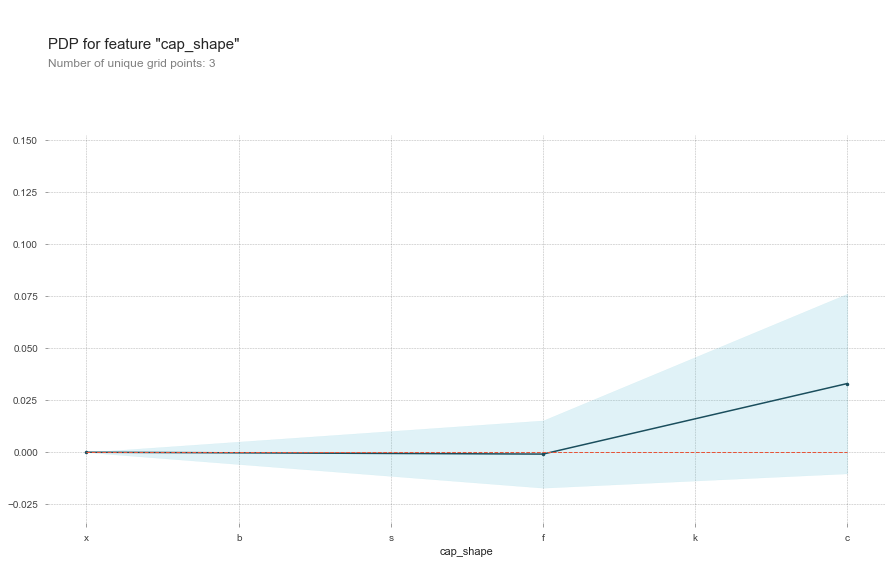

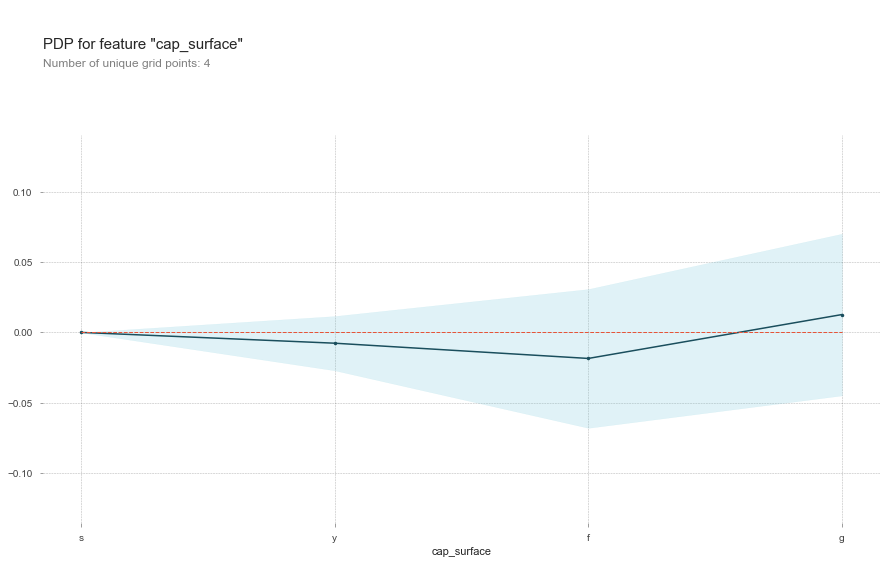

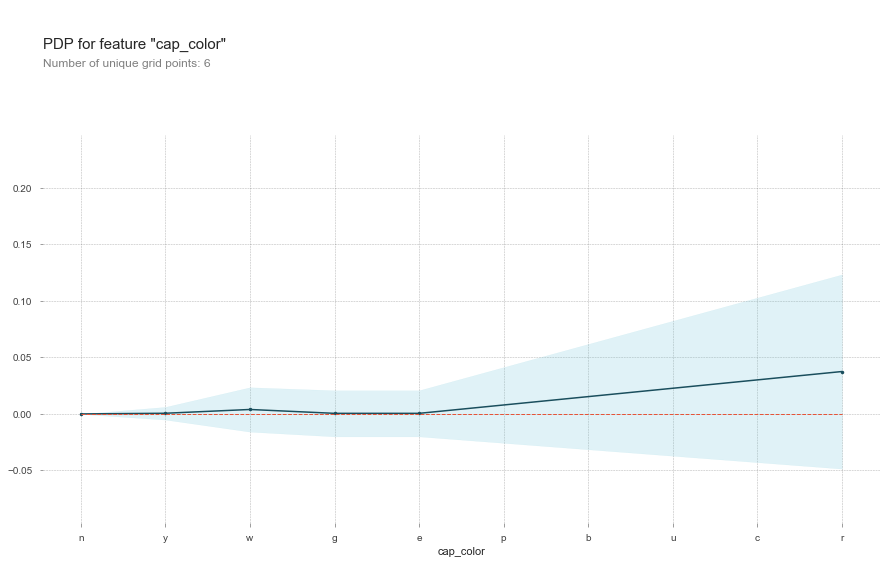

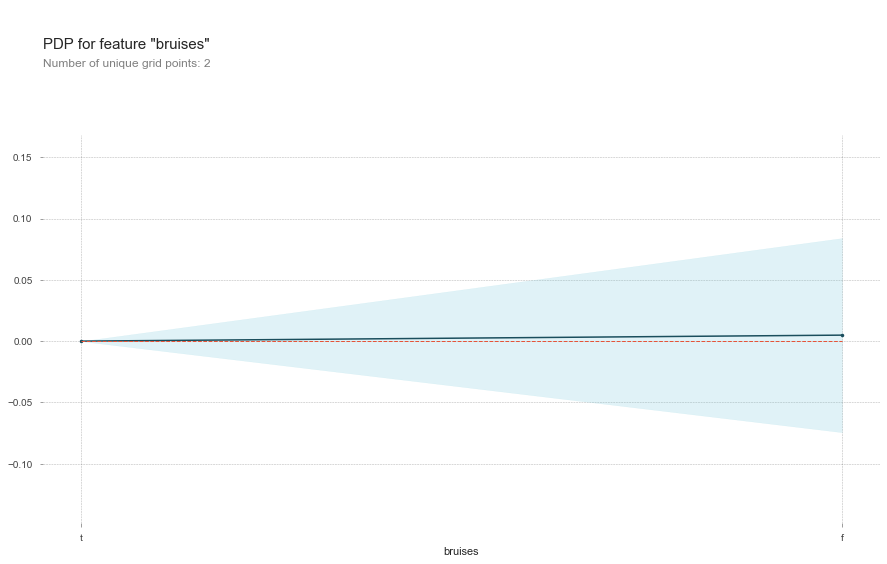

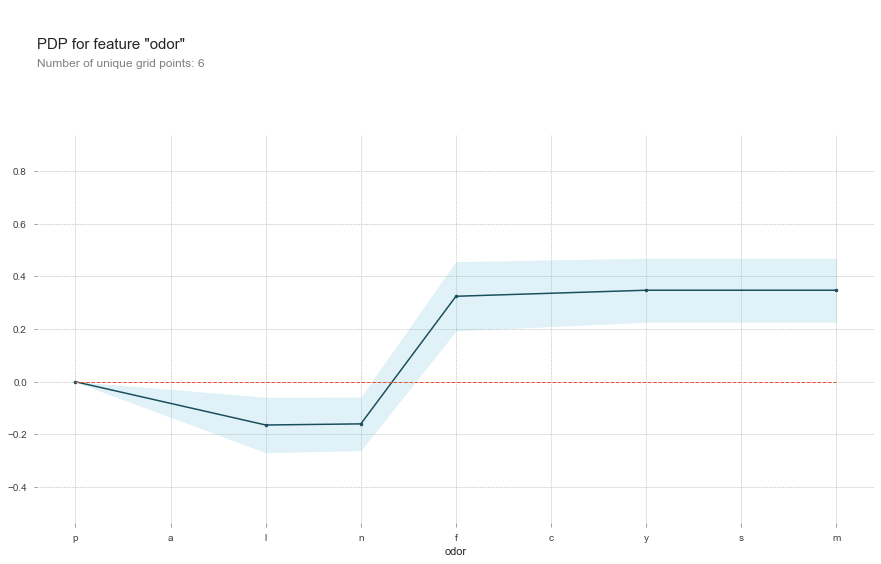

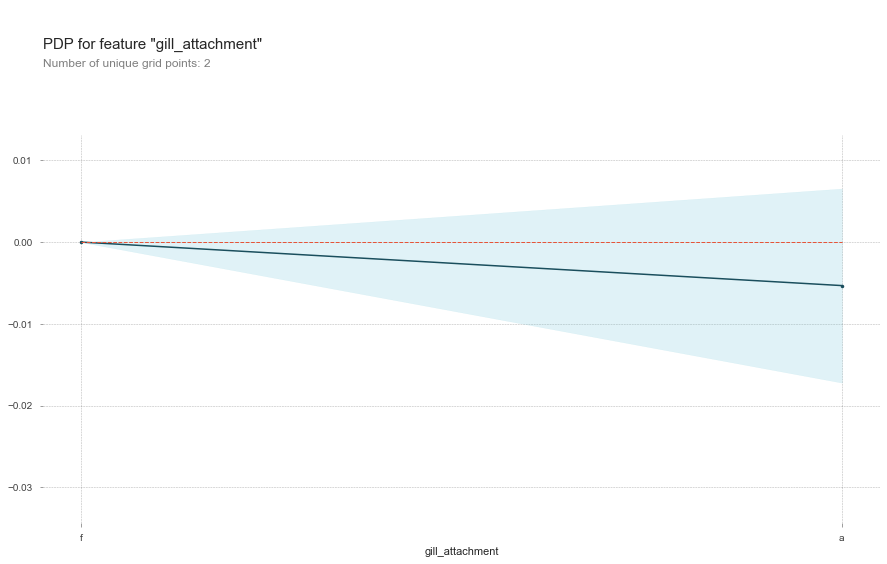

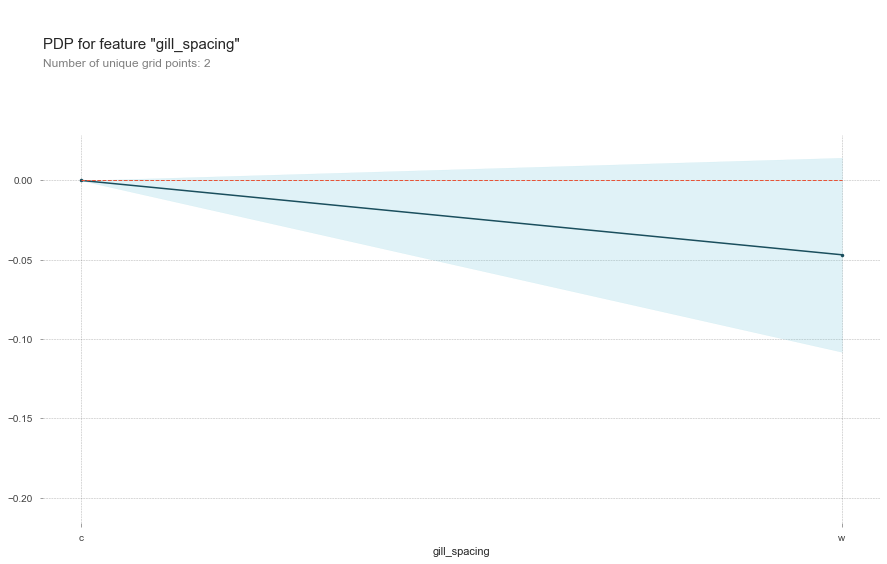

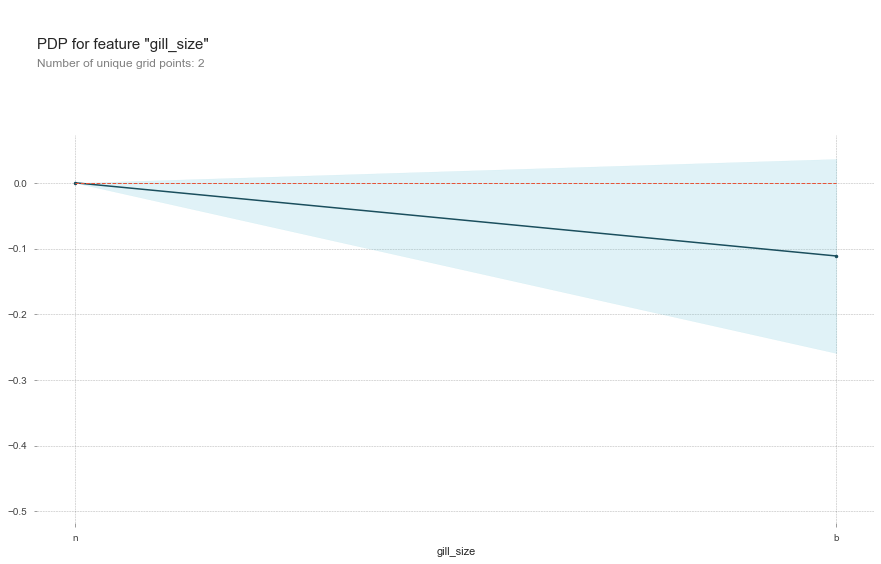

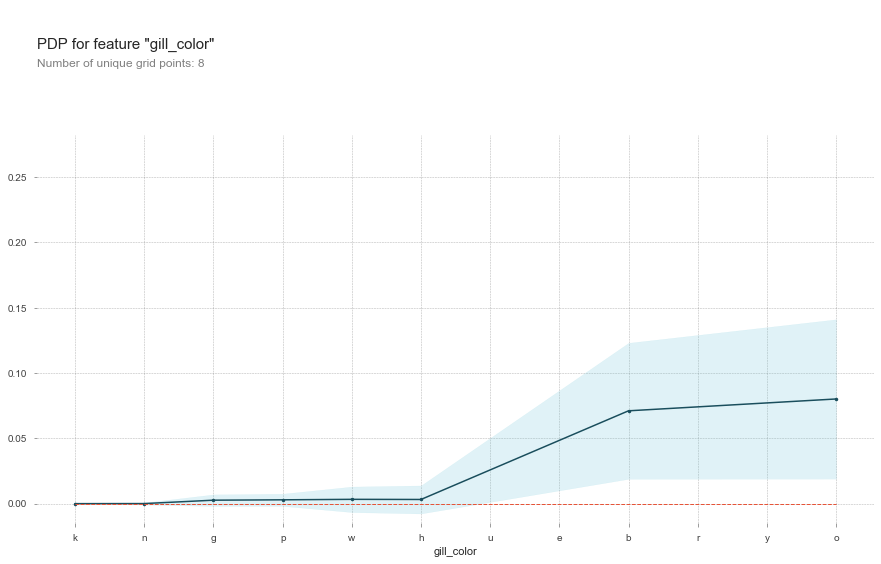

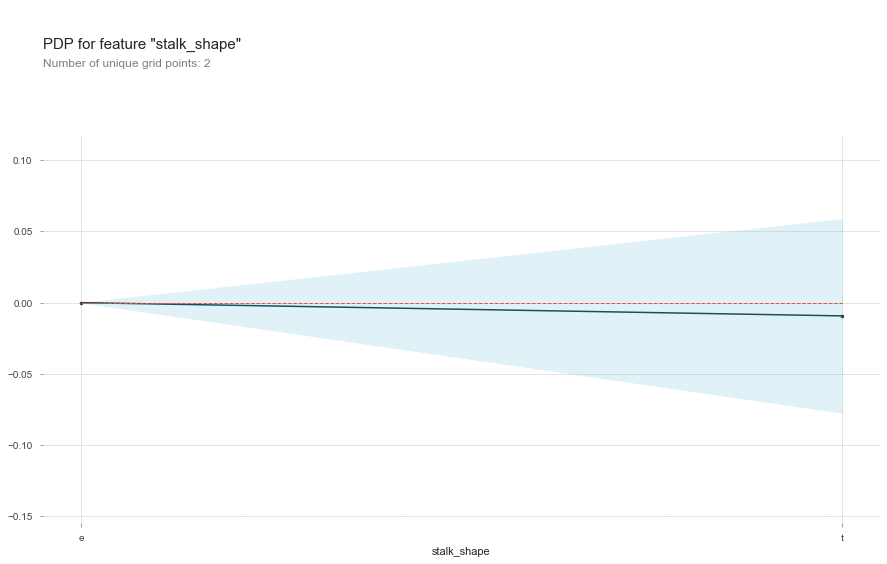

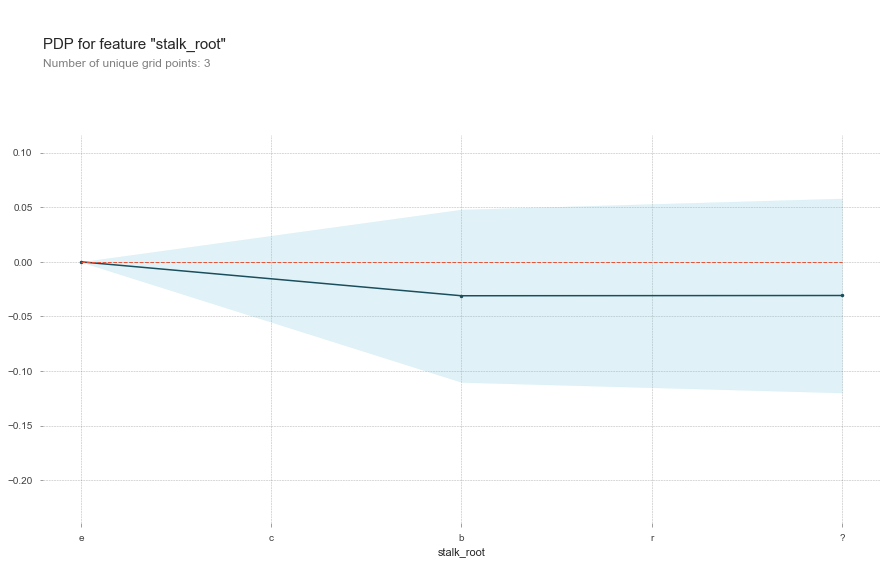

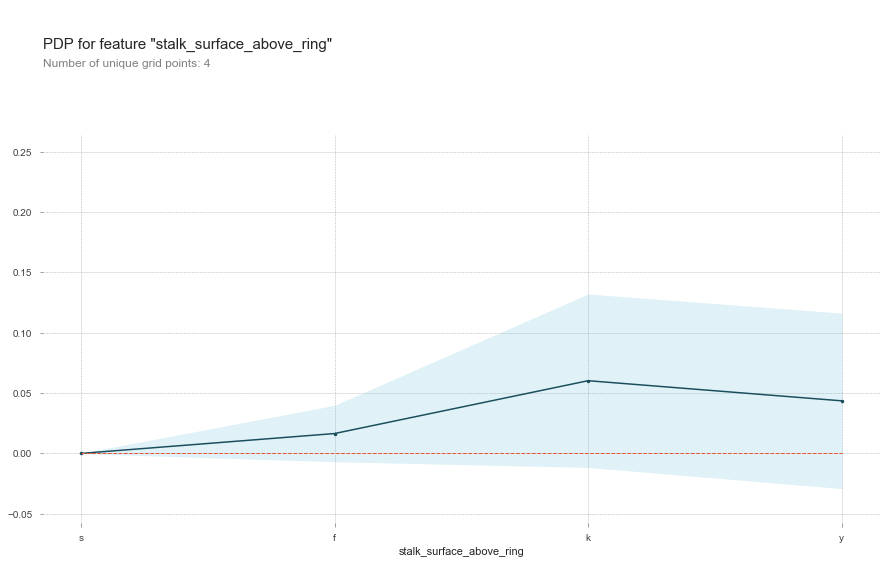

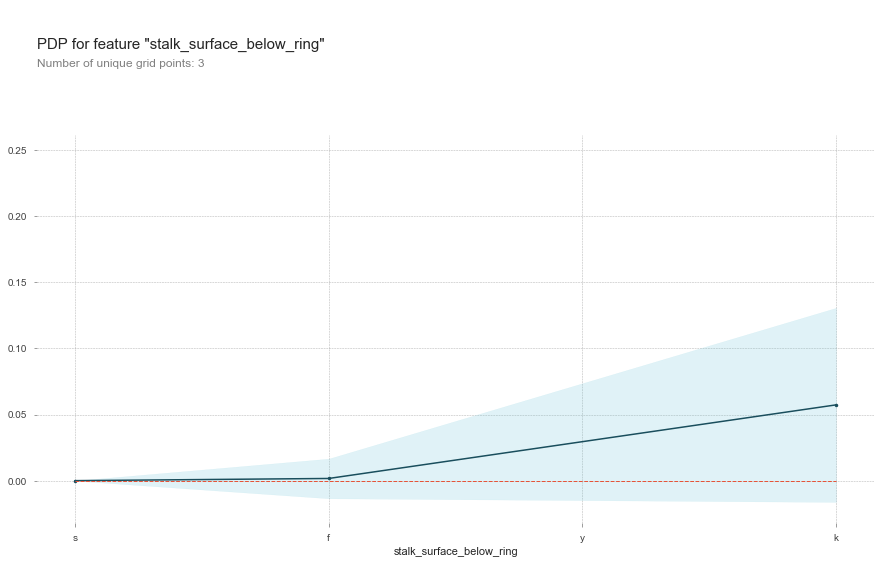

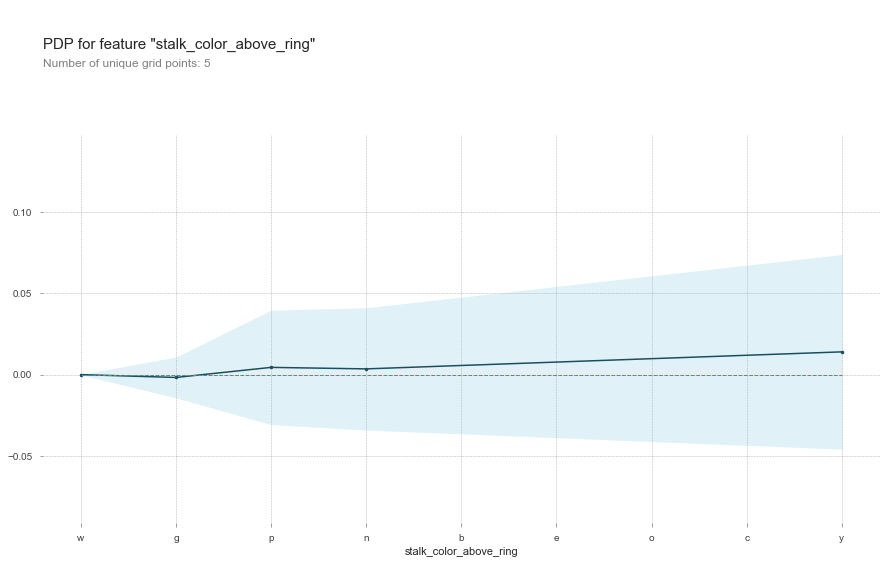

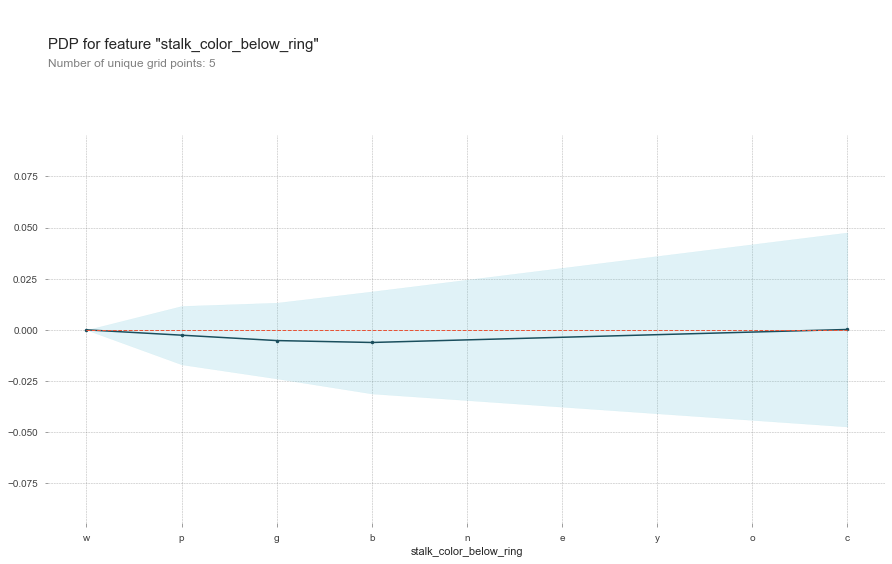

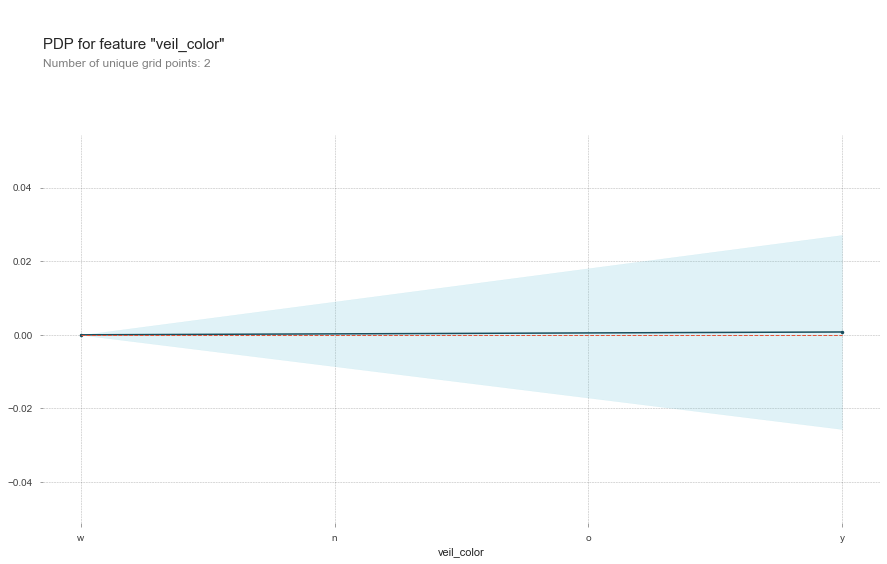

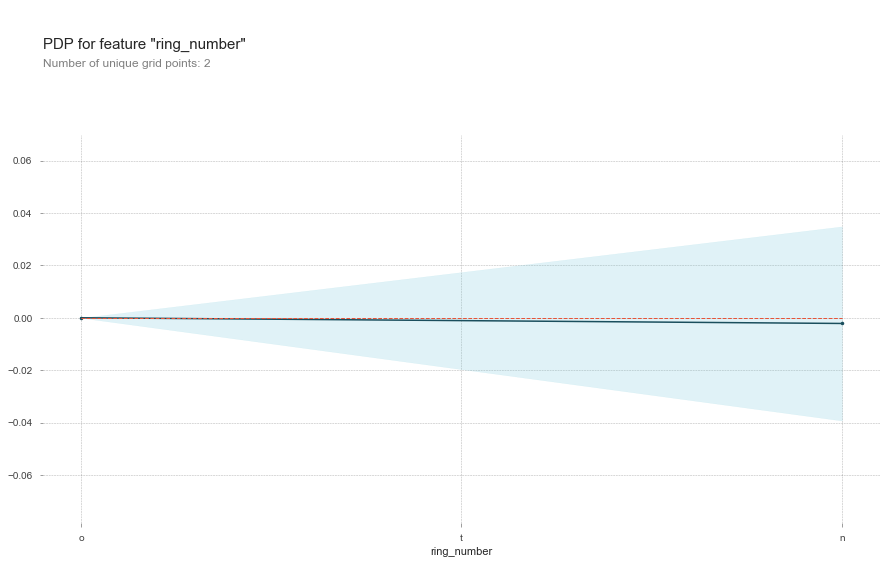

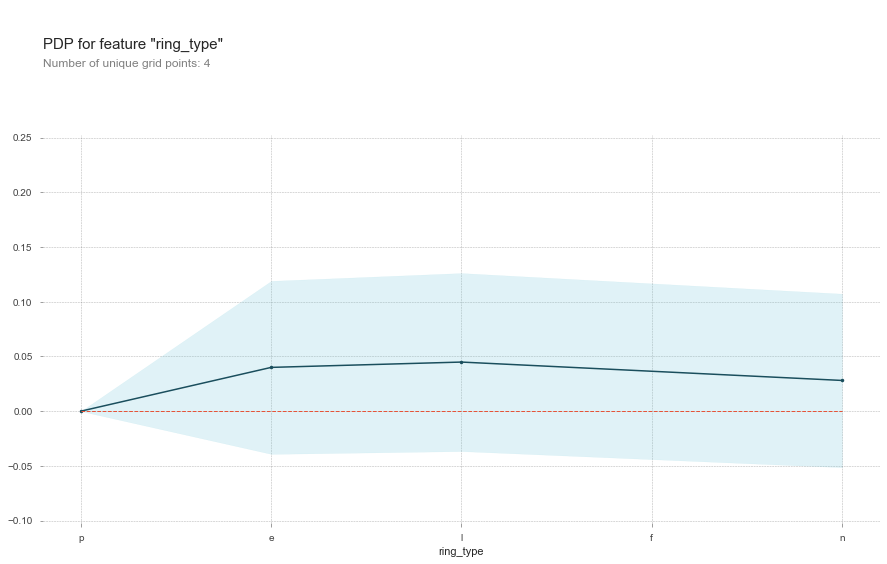

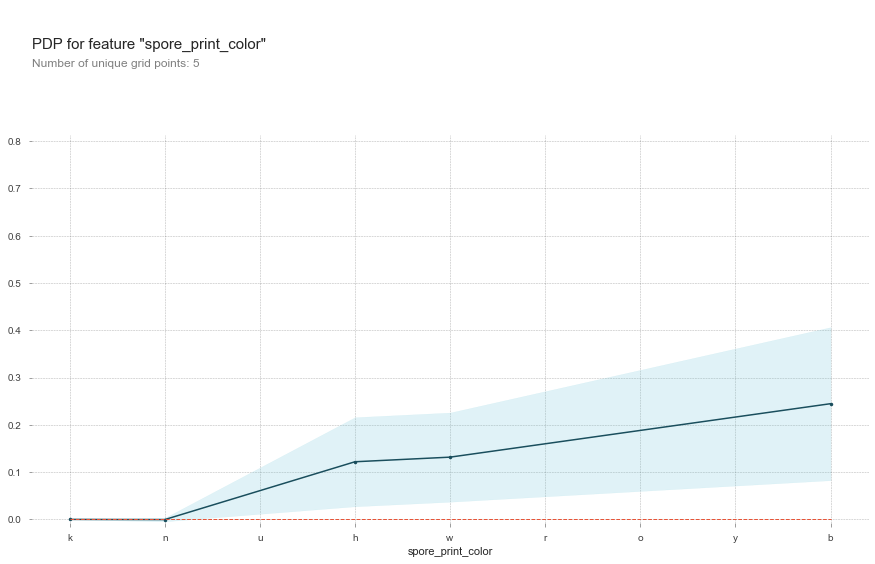

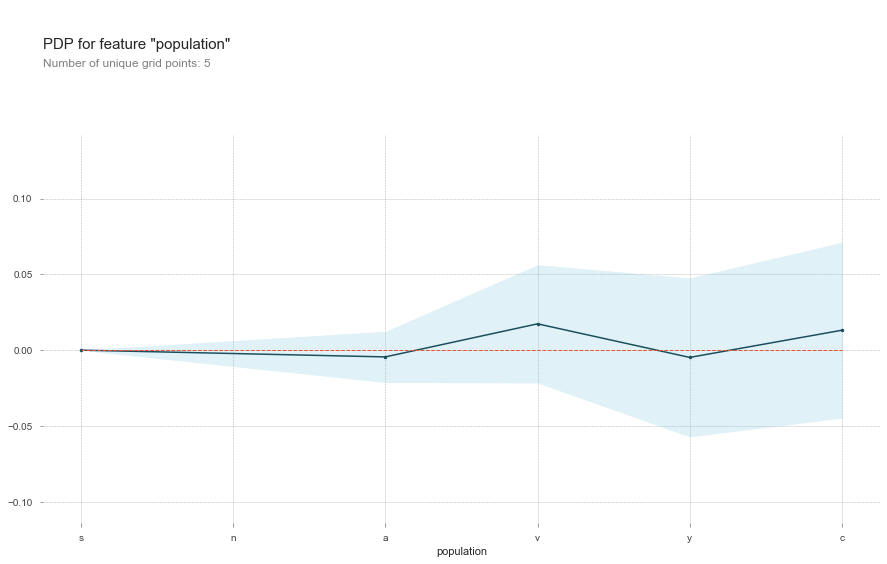

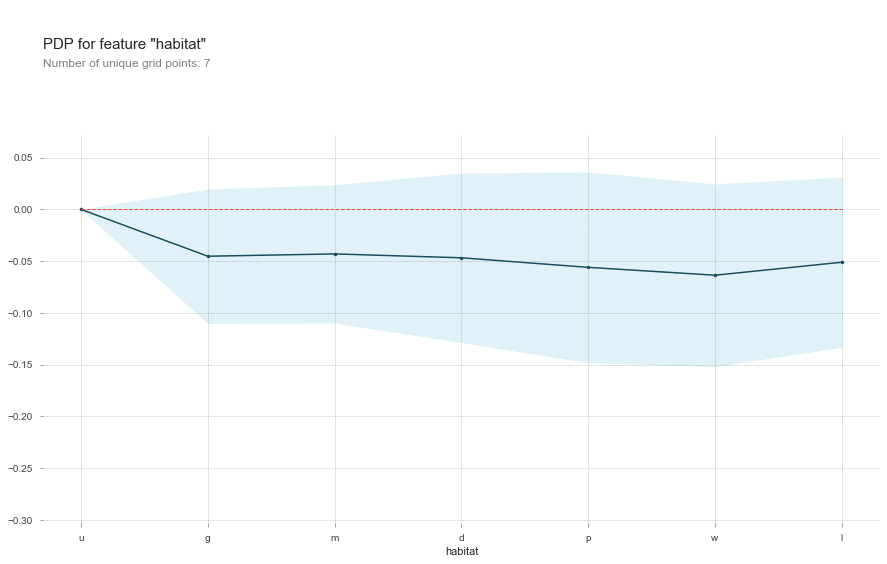

In [45]:
for f in features:
    feature = f
    pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
    for item in encoder.mapping:
        if item['col'] == feature:
            feature_mapping = item['mapping']
        
    feature_mapping = feature_mapping[feature_mapping.index.dropna()]
    category_names = feature_mapping.index.tolist()
    category_codes = feature_mapping.values.tolist()
    
    pdp.pdp_plot(pdp_dist, feature)
    # Automatically change the xticks labels
    plt.xticks(category_codes, category_names)
    plt.show();
    